スパースモデリング第15章　その他の応用
==
インパルスノイズのフィルタリング

In [10]:
from matplotlib.font_manager import FontProperties
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from skimage.io import imread
from scipy.ndimage.filters import median_filter

font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

def get_psnr(im, recon):
    """ PSNRを得る """ 
    return 10. * np.log(im.max() / np.sqrt(np.mean((im - recon) ** 2)))

def show_dictionary(A, name=None, figsize=(4, 4), vmin=None, vmax=None):
    """ 辞書を表示 """
    n = int(np.sqrt(A.shape[0]))
    m = int(np.sqrt(A.shape[1]))
    A_show = A.reshape((n, n, m, m))
    fig, ax = plt.subplots(m, m, figsize=figsize)
    for row in range(m):
        for col in range(m):
            ax[row, col].imshow(A_show[:, :, col, row], cmap='gray', interpolation='Nearest', vmin=vmin, vmax=vmax)
            ax[row, col].axis('off')
    if name is not None:
        plt.savefig(name, dpi=220)
        
def OMP(A, b, k0, eps):
    """ 
    直交マッチング追跡(orthogonal matching pursuit; OMP) 
    
    A nxm行列
    b n要素の観測
    k0 xの非ゼロの要素数
    eps 誤差の閾値
    
    戻り値
    x m要素のスパース表現
    S m要素のサポートベクトル
    """
    # 初期化
    x = np.zeros(A.shape[1])
    S = np.zeros(A.shape[1], dtype=np.uint8)
    r = b.copy()
    rr = np.dot(r, r)
    for _ in range(k0):
        # 誤差計算
        err = rr - np.dot(A[:, S == 0].T, r) ** 2
            
        # サポート更新
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
    
        # 解更新
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S == 1] = np.dot(As.T, np.dot(pinv, b))
        
        # 残差更新
        r = b - np.dot(A, x)
        rr = np.dot(r, r)
        if rr < eps:
            break
            
    return x, S

Peppers
--

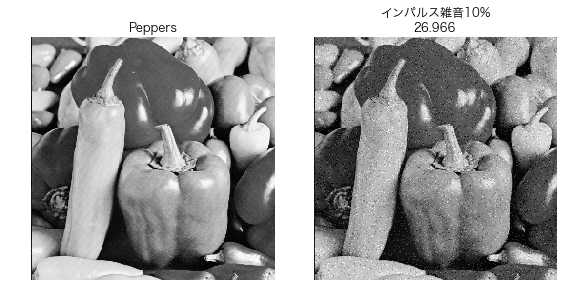

In [11]:
im = imread('peppers.png', as_grey=True)[::2, ::2] * 255
if False:
    mask = np.random.rand(im.shape[0], im.shape[1]) <= 0.1
    sign = np.sign(np.random.rand(im.shape[0], im.shape[1]) - 0.5) * (mask > 0)
    Y = np.clip(im + 50. * sign, 0, 255)
    Y.tofile('Peppers_inpulse')
    mask.tofile('Peppers_inpulse_mask')
    sign.tofile('Peppers_inpulse_sign')
else:
    Y = np.fromfile('Peppers_inpulse').reshape(im.shape)
    mask = np.fromfile('Peppers_inpulse_mask', dtype=np.uint8).reshape(im.shape)
    sign = np.fromfile('Peppers_inpulse_sign').reshape(im.shape)
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = ax.flatten()
ax[0].imshow(im, cmap='gray', interpolation='Nearest')
ax[1].imshow(Y, cmap='gray', interpolation='Nearest')
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Peppers')
ax[1].set_title('インパルス雑音10%\n{:.3f}'.format(get_psnr(im, Y)))
plt.tight_layout()
plt.savefig('Peppers_inpulse.png', dpi=220)

メディアンフィルタ
--

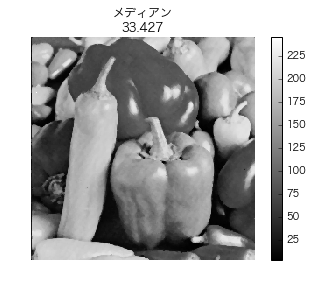

In [12]:
recon_median = median_filter(Y, size=3)
recon_median.tofile('Peppers_inpulse_recon_median')

plt.imshow(recon_median, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.colorbar()
plt.title('メディアン\n{:.3f}'.format(get_psnr(im, recon_median)))

推定マスク
--

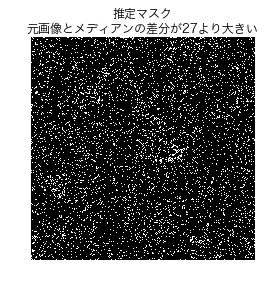

In [14]:
mask_median = np.abs(Y - recon_median) > 27
mask_median.tofile('Peppers_inpulse_mask_median')

plt.imshow(mask_median, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.title('推定マスク\n元画像とメディアンの差分が27より大きい')
plt.savefig('mask_median.png', dpi=220)

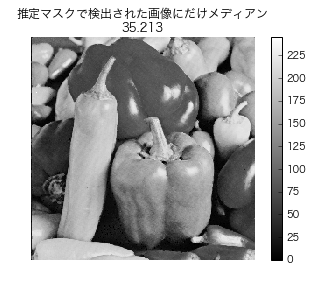

In [12]:
recon_median_mask = Y.copy()
recon_median_mask[mask_median] = recon_median[mask_median]
recon_median_mask.tofile('Peppers_inpulse_recon_median_mask')

plt.imshow(recon_median_mask, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.colorbar()
plt.title('推定マスクで検出された画像にだけメディアン\n{:.3f}'.format(get_psnr(im, recon_median_mask)))

冗長DCT辞書
--

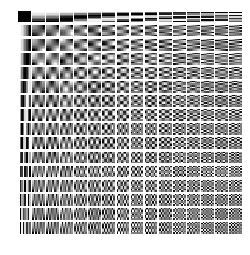

In [6]:
patch_size = 8
dict_size = 16
A_1D = np.zeros((patch_size, dict_size))
for k in np.arange(dict_size):
    for i in np.arange(patch_size):
        A_1D[i, k] = np.cos(i * k * np.pi / float(dict_size))
    if k != 0:
        A_1D[:, k] -= A_1D[:, k].mean()

A_DCT = np.kron(A_1D, A_1D)
A_DCT.tofile('A_DCT')
A_DCT = np.fromfile('A_DCT').reshape((patch_size ** 2, dict_size ** 2))
show_dictionary(A_DCT)

マスク付きスパース符号化
--

In [8]:
def sparse_coding_with_mask(im, A, k0, sig, mask, patch_size=8):
    """ マスク付きスパース符号化 """        
    patches = extract_patches_2d(im, (patch_size, patch_size))
    mask_patches = extract_patches_2d(mask, (patch_size, patch_size))
    q = np.zeros((len(patches), A.shape[1]))
    for i, (patch, mask_patch) in enumerate(zip(patches, mask_patches)):
        if i % 1000 == 0:
            print(i)
        A_mask = A[mask_patch.flatten() == 1, :]
        patch_mask = patch[mask_patch == 1]
        eps = len(patch_mask) * (sig ** 2) * 1.1
        q[i], _ = OMP(A_mask, patch_mask, k0, eps=eps)
    return q

def recon_image(im, q, A, lam=0.5, patch_size=8):
    """ 画像の再構成 """
    recon_patches = (np.dot(A, q.T).T).reshape((-1, patch_size, patch_size))
    recon = reconstruct_from_patches_2d(recon_patches, im.shape)
    return (im * lam + recon) / (lam + 1.)

In [13]:
sig = 5
q = sparse_coding_with_mask(Y, A_DCT, A_DCT.shape[1], sig, mask_median == 0)
q.tofile('Peppers_q_dct_local_inpainting_mask')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000


In [14]:
q = np.fromfile('Peppers_q_dct_local_inpainting_mask').reshape((-1, dict_size ** 2))
recon_dct_local_inpainting = recon_image(Y, q, A_DCT, lam=0)
recon_dct_local_inpainting_mask = Y.copy()
recon_dct_local_inpainting_mask[mask_median] =  recon_dct_local_inpainting[mask_median]
recon_dct_local_inpainting_mask.tofile('Peppers_inpulse_recon_dct_local_inpainting_mask')

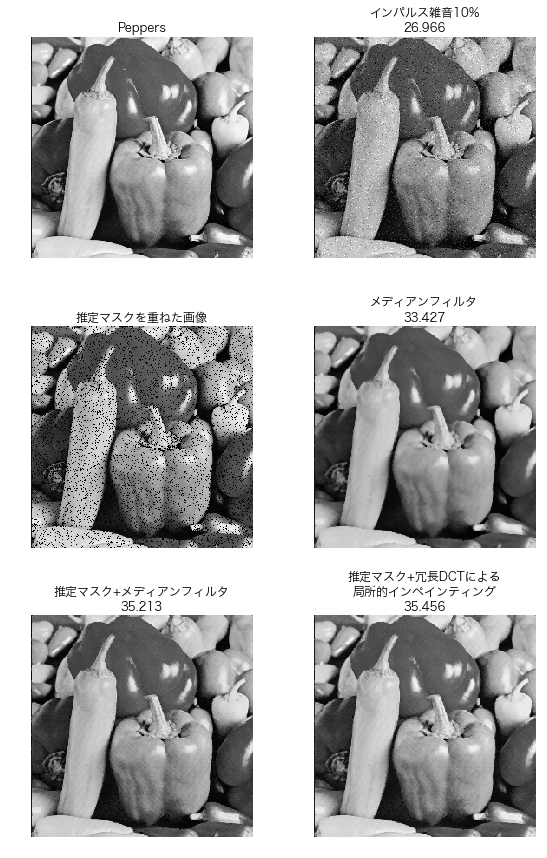

In [9]:
im = imread('peppers.png', as_grey=True)[::2, ::2] * 255
Y = np.fromfile('Peppers_inpulse').reshape(im.shape)
recon_median = np.fromfile('Peppers_inpulse_recon_median').reshape(im.shape)
mask_median = np.fromfile('Peppers_inpulse_mask_median', dtype=np.uint8).reshape(im.shape)
recon_median_mask = np.fromfile('Peppers_inpulse_recon_median_mask').reshape(im.shape)
recon_dct_local_inpainting_mask = np.fromfile('Peppers_inpulse_recon_dct_local_inpainting_mask').reshape(im.shape)

fig, ax = plt.subplots(3, 2, figsize=(8, 12))
ax = ax.flatten()
ax[0].imshow(im, cmap='gray', interpolation='Nearest')
ax[1].imshow(Y, cmap='gray', interpolation='Nearest')
ax[2].imshow(Y * (mask_median == 0), cmap='gray', interpolation='Nearest')
ax[3].imshow(recon_median, cmap='gray', interpolation='Nearest')
ax[4].imshow(recon_median_mask, cmap='gray', interpolation='Nearest')
ax[5].imshow(recon_dct_local_inpainting_mask, cmap='gray', interpolation='Nearest')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')
ax[5].axis('off')
ax[0].set_title('Peppers')
ax[1].set_title('インパルス雑音10%\n{:.3f}'.format(get_psnr(im, Y)))
ax[2].set_title('推定マスクを重ねた画像')
ax[3].set_title('メディアンフィルタ\n{:.3f}'.format(get_psnr(im, recon_median)))
ax[4].set_title('推定マスク+メディアンフィルタ\n{:.3f}'.format(get_psnr(im, recon_median_mask)))
ax[5].set_title('推定マスク+冗長DCTによる\n局所的インペインティング\n{:.3f}'.format(get_psnr(im, recon_dct_local_inpainting_mask)))

plt.tight_layout()
plt.savefig('Peppers_inpulse_recon.png', dpi=220)

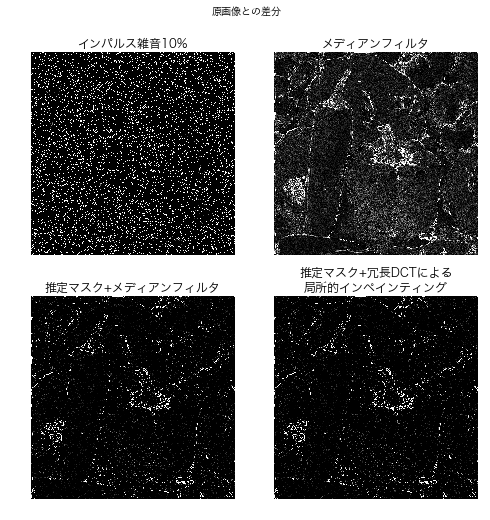

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
ax[0].imshow(np.abs(im - Y), cmap='gray', interpolation='Nearest', vmin=0, vmax=25)
ax[1].imshow(np.abs(im - recon_median), cmap='gray', interpolation='Nearest', vmin=0, vmax=25)
ax[2].imshow(np.abs(im - recon_median_mask), cmap='gray', interpolation='Nearest', vmin=0, vmax=25)
ax[3].imshow(np.abs(im - recon_dct_local_inpainting_mask), cmap='gray', interpolation='Nearest', vmin=0, vmax=25)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
plt.suptitle('原画像との差分')
ax[0].set_title('インパルス雑音10%')
ax[1].set_title('メディアンフィルタ')
ax[2].set_title('推定マスク+メディアンフィルタ')
ax[3].set_title('推定マスク+冗長DCTによる\n局所的インペインティング')
# plt.tight_layout()
plt.savefig('Peppers_inpulse_recon_sub.png', dpi=220)